In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [24]:
'''
1) MODEL SELECTION
'''
'''
Setup dataset
'''
GRANULARITY = 500 # Used for plot smoothness (higher is better)
FIGSIZE = [10, 7]

# Load the examples
train_1 = pd.read_csv(r'./Datasets/Dataset_1_train.csv', header=None)
valid_1 = pd.read_csv(r'./Datasets/Dataset_1_valid.csv', header=None)
test_1 = pd.read_csv(r'./Datasets/Dataset_1_test.csv', header=None)

# This makes it easier to work on all sets simultaneously
example_set = {'train': train_1, 'valid': valid_1, 'test': test_1}
output_set = {}

print(train_1.head())

          0          1   2
0  0.516220   1.609671 NaN
1  0.850085  14.814006 NaN
2 -0.840629  -8.738649 NaN
3  0.227433  -0.274344 NaN
4 -0.649508  -8.683412 NaN


In [25]:
'''
Part 1: Fit 20 degree polynomial
'''
MAX_DEGREE = 20

# Create the x axis for the fit (this is used for plotting the fit)
x_axis = pd.DataFrame(np.ones(GRANULARITY))
x_axis[1] = np.arange(-1, 1, 2 / GRANULARITY)
for i in range(2, MAX_DEGREE + 1):
    x_axis[i] = pow(x_axis[1], i)
    
# Preprocessing of input
for key in example_set:
    # Separate y from features
    output_set[key] = example_set[key][1]
    example_set[key].drop([1, 2], axis=1, inplace=True) # drop y column and null column from original dataframe
    # Add column of 1s as bias
    example_set[key].columns = [1]
    example_set[key][0] = 1.
    example_set[key] = example_set[key][[0, 1]]

print(example_set['train'].head())
print(output_set['train'].head())

     0         1
0  1.0  0.516220
1  1.0  0.850085
2  1.0 -0.840629
3  1.0  0.227433
4  1.0 -0.649508
0     1.609671
1    14.814006
2    -8.738649
3    -0.274344
4    -8.683412
Name: 1, dtype: float64


In [27]:
# Generate polynomial features up to x^20. We already have bias and x^1
for i in range(2, MAX_DEGREE + 1):
    for _, df in example_set.items():
        df[i] = np.power(df[1], i)

C:\Users\Nabil\Desktop\COMP551ASSIGNMENTS\env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [28]:
print(example_set['train'].head())

    0         1         2         3         4         5         6         7   \
0  1.0  0.516220  0.266483  0.137564  0.071013  0.036658  0.018924  0.009769   
1  1.0  0.850085  0.722644  0.614308  0.522214  0.443926  0.377375  0.320800   
2  1.0 -0.840629  0.706656 -0.594035  0.499363 -0.419779  0.352878 -0.296639   
3  1.0  0.227433  0.051726  0.011764  0.002676  0.000609  0.000138  0.000031   
4  1.0 -0.649508  0.421860 -0.274002  0.177966 -0.115590  0.075077 -0.048763   

         8         9       ...                 11            12            13  \
0  0.005043  0.002603      ...       6.937138e-04  3.581088e-04  1.848628e-04   
1  0.272707  0.231824      ...       1.675264e-01  1.424116e-01  1.210619e-01   
2  0.249364 -0.209622      ...      -1.481308e-01  1.245230e-01 -1.046776e-01   
3  0.000007  0.000002      ...       8.421386e-08  1.915299e-08  4.356018e-09   
4  0.031672 -0.020571      ...      -8.678179e-03  5.636546e-03 -3.660981e-03   

             14            15   

In [29]:
# Convert to numpy arrays (makes it faster)
for key in example_set:
    example_set[key] = np.array(example_set[key], dtype=np.float64)
    output_set[key] = np.array(output_set[key], dtype=np.float64)

In [30]:
def fit(X, y, lambda_reg=0):
    '''
    Uses least-squares closed-form solution to obtain the optimal weights

    :param X: The input matrix of shape N x M
    :param y: The output vector N x 1
    :param lambda_reg: The regularization term. lambda_reg=0 means no regularization
    :return: The optimal weights as an M x 1 vector
    '''
    identity = np.identity(X.shape[1])
    # identity[0, 0] = 0 # We do not penalize the bias term
    X_square = np.matmul(np.transpose(X), X) + lambda_reg * identity
    X_square_inverse = np.linalg.pinv(X_square)
    weights = np.matmul(np.matmul(X_square_inverse, np.transpose(X)), y)

    return weights

def mean_square_error(X, y, W):
    '''
    Comptes the MSE of the dataset
    :param X: The input matrix of shape N x M
    :param y: The output vector N x 1
    :param W: Weights M x 1
    :return: MSE
    '''
    y_hat = np.matmul(X, W)
    mean_square_err = np.sum(np.square(y - y_hat)) / len(y)

    return mean_square_err

def visualize(W, visualize_all=False, X=None, y=None, title_for_all="", title_for_x="", save_all_as=None, save_x_as=None):
    '''
    Convenience function used for plotting
    :param W: The weights of the model
    :param visualize_all: Visualize all sets
    :param X: Visualize the given input X
    :param y: The output associated with input X
    :param title_for_all: Title for plot if visualize_all is set
    :param title_for_x: Title for plot if X is given
    :param save_all_as: Save the plot generated if visualize_all is set
    :param save_x_as: Save the plot generated for input X and associated output y
    '''
    global x_axis
    model_fit = np.matmul(x_axis, W)

    # Visualize fit on all three sets of data
    fig_no = 1
    if visualize_all:
        plt.figure(fig_no, figsize=FIGSIZE)
        fig_no += 1
        for i, key in enumerate(example_set, 1):
            plt.subplot(len(example_set), 1, i)
            plt.scatter(example_set[key][:, 1], output_set[key])
            plt.plot(x_axis[1], model_fit, 'r--')
            plt.title(title_for_all + ": " + key.upper())
            plt.xlabel('x')
            plt.ylabel('y')
            plt.ylim([-22, 40])
        plt.tight_layout()
        if save_all_as:
            plt.savefig('./plots/' + save_all_as,  bbox_inches='tight')

    if not(X is None or y is None):
        plt.figure(fig_no, figsize=FIGSIZE)
        plt.scatter(X[:, 1], y)
        plt.plot(x_axis[1], model_fit, 'r--')
        plt.title(title_for_x)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim([-22, 40])
        if save_x_as:
            plt.savefig('./plots/' + save_x_as,  bbox_inches='tight')
    plt.show()

In [31]:
# Calculate the optimal weights based on the TRAINING examples (no regularization)
weights_no_reg = fit(example_set['train'], output_set['train'])
# Display MSEs for each set
for key in example_set:
    print('MSE for', key, 'set :', mean_square_error(example_set[key], output_set[key], weights_no_reg))

MSE for train set : 7.152591698311463
MSE for valid set : 458.64632551158587
MSE for test set : 17.251634115806542


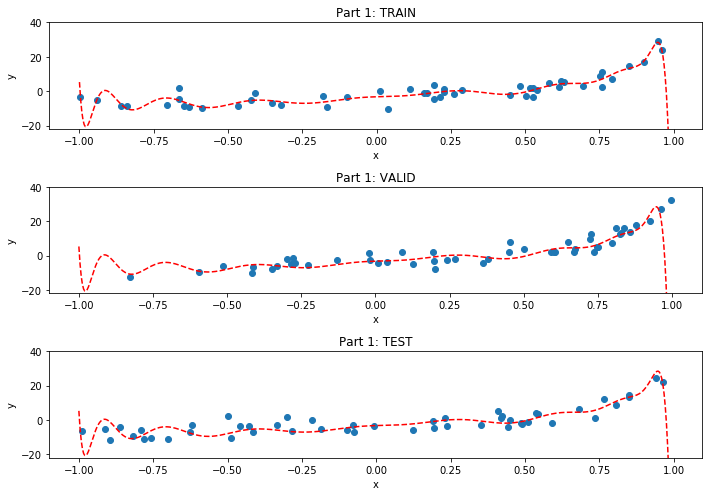

In [32]:
# Observe the curve on all datasets
visualize(weights_no_reg, visualize_all=True, title_for_all='Part 1', save_all_as='q1p1.png')

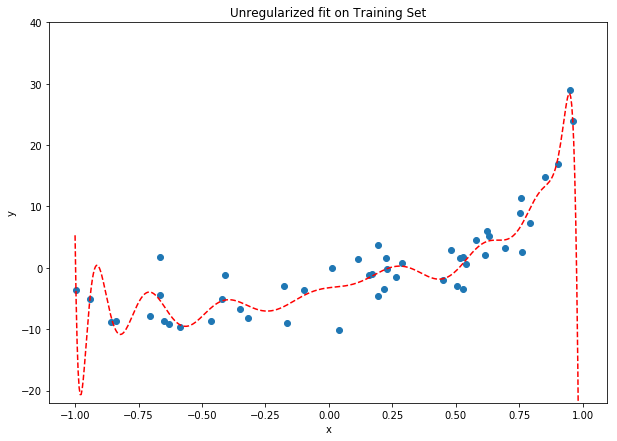

In [33]:
# Observe overfit on training dataset
visualize(weights_no_reg, X=example_set['train'], y=output_set['train'], title_for_x='Unregularized fit on Training Set', save_x_as='q1p12.png')

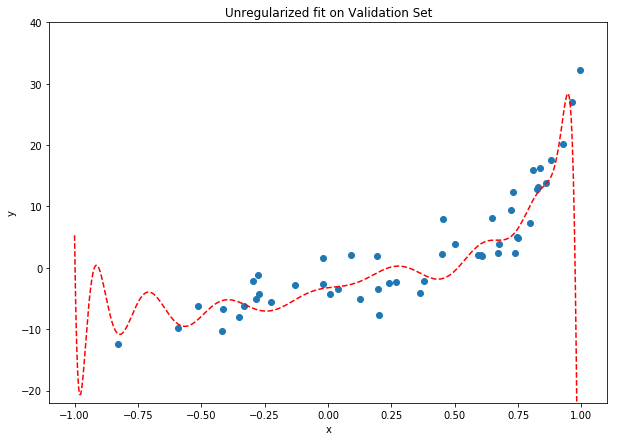

In [34]:
# Observe that the model does not fit the validation set well
visualize(weights_no_reg, X=example_set['valid'], y=output_set['valid'], title_for_x='Unregularized fit on Validation Set', save_x_as='q1p13.png')

In [35]:
'''
Part 2: Add L2 regularization
'''
INCREMENTS = 10000

train_mse = []
valid_mse = []
best_lambda = 9999999
lowest_mse = 9999999
for i in range(INCREMENTS + 1):
    # Calculate w with on the TRAINING set using regularization
    cur_lambda = 1 / INCREMENTS * i
    w = fit(example_set['train'], output_set['train'], cur_lambda)
    # Use w to compute MSE
    mse_train = mean_square_error(example_set['train'], output_set['train'], w)
    mse_valid = mean_square_error(example_set['valid'], output_set['valid'], w)

    train_mse.append(mse_train)
    valid_mse.append(mse_valid)

    # Track the best lambda based on MSE for validation set
    if mse_valid < lowest_mse:
        lowest_mse = mse_valid
        best_lambda = cur_lambda

print('Best Lambda:', best_lambda)

Best Lambda: 0.019700000000000002


In [36]:
# Calculate optimal weights using best_lambda
OPT_WEIGHTS = fit(example_set['train'], output_set['train'], best_lambda)

# # Test performance
# test_mse = mean_square_error(example_set['test'], output_set['test'] , OPT_WEIGHTS)
# 
# print('MSE of test set with regularization:', test_mse)

# Display MSEs for each set
for key in example_set:
    print('MSE for', key, 'set with regularization:', mean_square_error(example_set[key], output_set[key], OPT_WEIGHTS))

MSE for train set with regularization: 8.856456800480235
MSE for valid set with regularization: 9.13508347300787
MSE for test set with regularization: 10.732301005330791


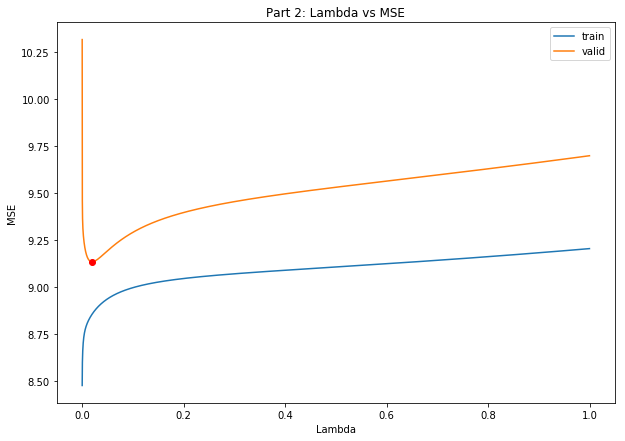

In [37]:
# Plot Lambda vs MSE for train and valid sets
plt.figure(figsize=FIGSIZE)
plt.plot(np.arange(0, 1, 1/INCREMENTS), train_mse[1:], label='train')
plt.plot(np.arange(0, 1, 1/INCREMENTS), valid_mse[1:], label='valid')
plt.plot([best_lambda], [lowest_mse], marker='o', markersize=6, color='r')
plt.title("Part 2: Lambda vs MSE")
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.legend()
plt.savefig('q1p14.png')
plt.show()

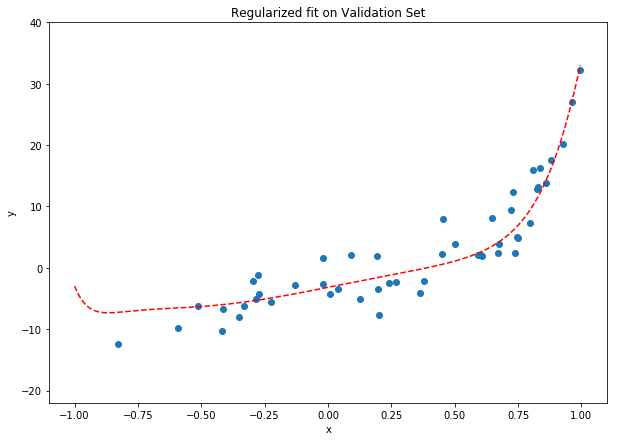

In [38]:
# Plot chosen model
visualize(OPT_WEIGHTS, X=example_set['valid'], y=output_set['valid'], title_for_x='Regularized fit on Validation Set', save_x_as='q1p15.png')

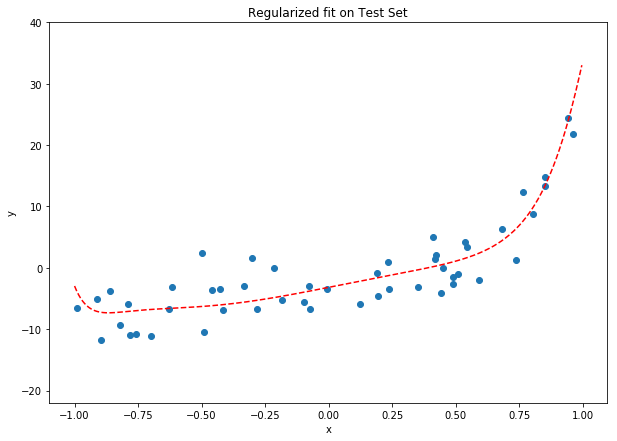

In [22]:
visualize(OPT_WEIGHTS, X=example_set['test'], y=output_set['test'], title_for_x='Regularized fit on Test Set', save_x_as='q1p16.png')